# Assignment 01: Multi-class Classification
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

### Hyperparameters

In [3]:
# random seed
SEED = 1
NUM_CLASS = 10

# Training
BATCH_SIZE = 64
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'
DATA_LOADER_WORKERS = 16

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

### Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_cifar10_dataloaders(BATCH_SIZE):
    transform_cifar10_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_cifar10_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                              download=True, transform=transform_cifar10_train)
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,num_workers=DATA_LOADER_WORKERS)

    test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                            download=True, transform=transform_cifar10_test)
    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=False,num_workers=DATA_LOADER_WORKERS)
    return train_dataloader, test_dataloader

### Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [7]:
def train_batch(model, image, target):

    output = model(image)
    loss = criterion(output,target)
    return output, loss

In [8]:
def test_batch(model, image, target):

    output = model(image)
    loss = criterion(output,target)

    return output, loss

In [9]:
def MAEL1Loss(X, y):
    Z = F.softmax(X, dim=1)
    Y = torch.zeros_like(X)
    Y[torch.arange(len(y)), y] = 1  # 使用索引设置正确类别的标签
    mae_loss = torch.mean(torch.abs(Z - Y))
    return mae_loss

def FocalLoss_1(X, y, gamma=0.5):
    X = F.softmax(X, dim=1)  # softmax在通道维度上进行
    n = len(y)

    # 生成一个one-hot编码的目标张量
    y_onehot = torch.zeros(X.size(), device=device)
    y_onehot.scatter_(1, y.view(-1, 1), 1)

    # 计算Focal Loss
    FL = -y_onehot * (1 - X) ** gamma * torch.log(X)
    FL = FL.sum(dim=1).mean()
    return FL

def FocalLoss_2(X, y, gamma=2):
    X = F.softmax(X, dim=1)  # softmax在通道维度上进行
    n = len(y)

    # 生成一个one-hot编码的目标张量
    y_onehot = torch.zeros(X.size(), device=device)
    y_onehot.scatter_(1, y.view(-1, 1), 1)

    # 计算Focal Loss
    FL = -y_onehot * (1 - X) ** gamma * torch.log(X)
    FL = FL.sum(dim=1).mean()
    return FL

In [10]:
# # 生成一个128×10的张量X，每个元素都在0到1之间随机
# X = np.random.rand(128, 10)

# # 生成一个128的张量y，其中每个数字都在0到9之间随机
# y = np.random.randint(0, 10, size=128)

# # 如果你需要将NumPy数组转换为PyTorch张量，可以使用以下代码
# import torch

# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.int64)
# FocalLoss_1(X,y)

### Loss function

In [11]:
# criterion = nn.CrossEntropyLoss()
criterion = MAEL1Loss
# criterion = FocalLoss_1
# criterion = FocalLoss_2

In [12]:
import os
import os.path as osp
import numpy as np


train_loader,test_loader = get_cifar10_dataloaders(BATCH_SIZE)

def train_and_test_model(model, train_loader, test_loader, optimizer, scheduler, NUM_EPOCHS, EVAL_INTERVAL, criterion, SAVE_DIR, device):
    training_loss = []
    training_acc = []
    testing_loss = []
    testing_acc = []
    confusion_matrix = np.zeros((10, 10))

    model.to(device)

    for epoch in range(NUM_EPOCHS):
        torch.cuda.empty_cache()
        model.train()

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_loader):
            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_loader.dataset)
        epoch_acc = running_cls_corrects.double() / len(train_loader.dataset)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_loader):
                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                # 更新混淆矩阵
                for t, p in zip(target.view(-1), preds.view(-1)):
                    confusion_matrix[t][p] += 1

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_loader.dataset)
            val_acc = val_corrects.double() / len(test_loader.dataset)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss.append(val_loss)
            testing_acc.append(val_acc.cpu().detach().numpy())

        if (epoch + 1) == NUM_EPOCHS:
            state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch + 1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(criterion))))

    return training_loss, training_acc, testing_loss, testing_acc, confusion_matrix
timer = Timer()
training_loss, training_acc, testing_loss, testing_acc, confusion_matrix = train_and_test_model(model, train_loader, test_loader, optimizer, scheduler, NUM_EPOCHS, EVAL_INTERVAL, criterion, SAVE_DIR, device)

f'train time :{timer.stop():.2f} sec'

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1/30 Train Loss: 0.0025 Acc: 0.2000
Begin test......
Test Loss: 0.0024 Acc: 0.2275
Epoch: 2/30 Train Loss: 0.0024 Acc: 0.2488
Begin test......
Test Loss: 0.0023 Acc: 0.2647
Epoch: 3/30 Train Loss: 0.0023 Acc: 0.2560
Begin test......
Test Loss: 0.0023 Acc: 0.2632
Epoch: 4/30 Train Loss: 0.0023 Acc: 0.2586
Begin test......
Test Loss: 0.0023 Acc: 0.2764
Epoch: 5/30 Train Loss: 0.0023 Acc: 0.2601
Begin test......
Test Loss: 0.0023 Acc: 0.2722
Epoch: 6/30 Train Loss: 0.0023 Acc: 0.2729
Begin test......
Test Loss: 0.0022 Acc: 0.2996
Epoch: 7/30 Train Loss: 0.0022 Acc: 0.2809
Begin test......
Test Loss: 0.0022 Acc: 0.2992
Epoch: 8/30 Train Loss: 0.0022 Acc: 0.2894
Begin test......
Test Loss: 0.0021 Acc: 0.3161
Epoch: 9/30 Train Loss: 0.0022 Acc: 0.2928
Begin test......
Test Loss: 0.0021 Acc: 0.3262
Epoch: 10/30 Train Loss: 0.0022 Acc: 0.2946
Begin test......
Test Loss: 0.0021 Acc: 0.3199
Epoch: 11/30 Train Loss

'train time :129.30 sec'

In [13]:
trl=pd.DataFrame(training_loss)
tra=pd.DataFrame(training_acc)
tel=pd.DataFrame(testing_loss)
tea=pd.DataFrame(testing_acc)
cm=pd.DataFrame(confusion_matrix)

# directory_path = 'CE'
directory_path = 'MAEL1_64'
# directory_path = 'Focal0.5'
# directory_path = 'Focal2'

os.makedirs(os.path.join(directory_path), exist_ok=True)

# trl.to_csv('/data/'+d+'/training_loss.csv', index=False)
# tra.to_csv('/data/'+d+'/training_acc.csv', index=False)
# tel.to_csv('/data/'+d+'/testing_loss.csv', index=False)
# tea.to_csv('/data/'+d+'/testing_acc.csv', index=False)
# cm.to_csv('/data/'+d+'/confusion_matrix.csv', index=False)

# 保存数据帧为CSV文件
trl.to_csv(os.path.join(directory_path, 'training_loss.csv'), index=False)
tra.to_csv(os.path.join(directory_path, 'training_acc.csv'), index=False)
tel.to_csv(os.path.join(directory_path, 'testing_loss.csv'), index=False)
tea.to_csv(os.path.join(directory_path, 'testing_acc.csv'), index=False)
cm.to_csv(os.path.join(directory_path, 'confusion_matrix.csv'), index=False)

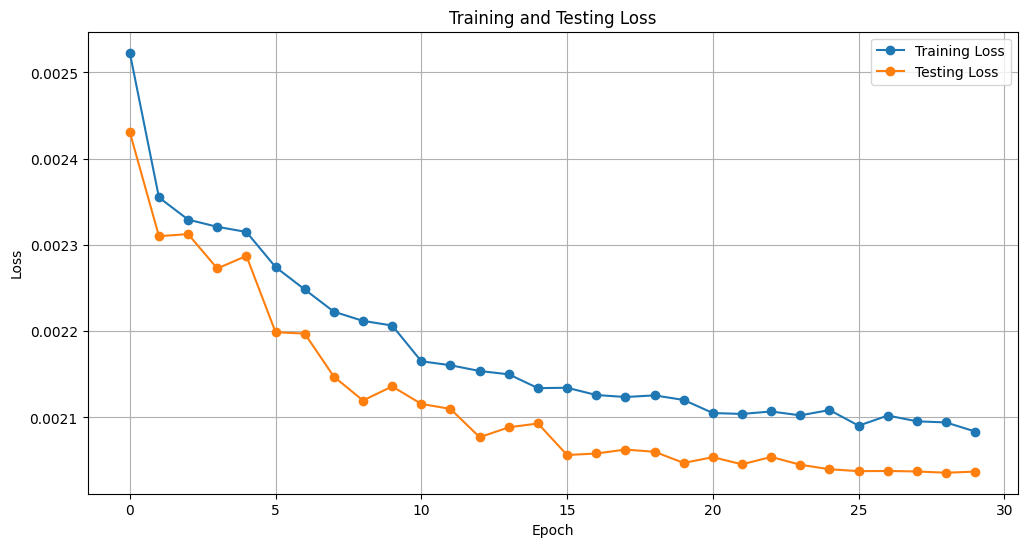

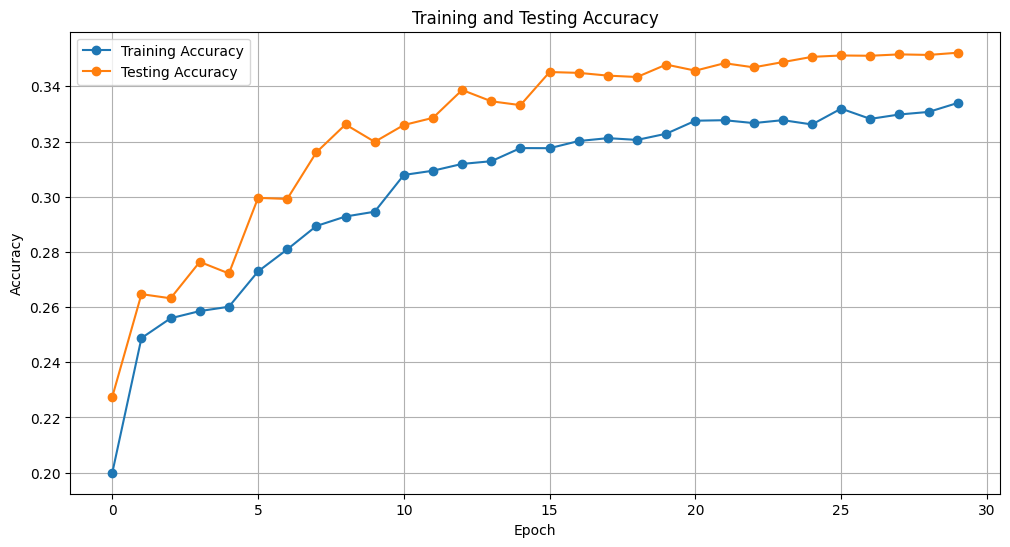

In [14]:
def plot_loss_and_accuracy(training_loss, testing_loss, training_acc, testing_acc):
    plt.figure(figsize=(12, 6))
    plt.plot(training_loss, label='Training Loss', marker='o')
    plt.plot(testing_loss, label='Testing Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(directory_path+'/loss_plot.png')  # 保存为 loss_plot.png
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(training_acc, label='Training Accuracy', marker='o')
    plt.plot(testing_acc, label='Testing Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(directory_path+'/accuracy_plot.png')  # 保存为 accuracy_plot.png
    plt.show()


# 假设已经有 training_loss, testing_loss, training_acc, testing_acc 这些列表
plot_loss_and_accuracy(training_loss, testing_loss, training_acc, testing_acc)



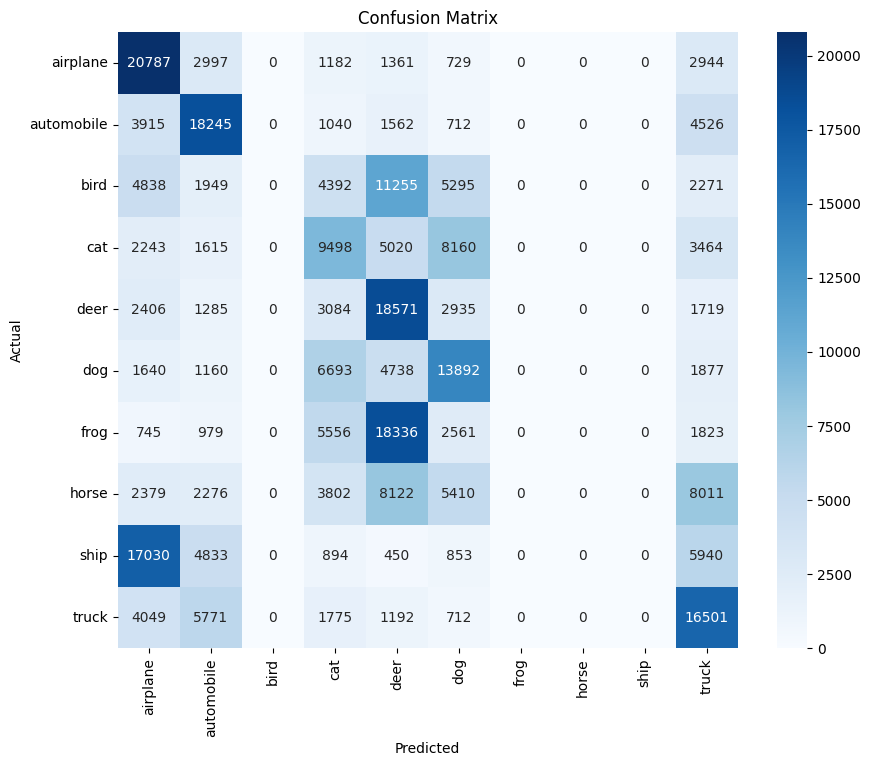

In [15]:
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(directory_path+'/confusion_matrix.png')  # 保存为 accuracy_plot.png
    plt.show()

# 示例用法
# 假设您已经有一个名为 confusion_matrix 的 2D 数组和 class_names 列表
plot_confusion_matrix(confusion_matrix, class_names)